# Demonstrating Oracle Rest Data Services with Python/Pandas

This is a DEMO using Oracle Rest Data Services (ORDS) REST enabled view objects and how to fetch data over
REST against and Oracle Database and then using Pandas to view data.

Ulf Hellström EpicoTech 2021 ulf.hellstrom@epicotech.se

To setup the database behind this demo you will need

- An oracle database (Free option is Oracle Express Edition 18c).
- Oracle Rest Database Service (ORDS) setup and configured for the database created.
- Oracle Application Express >= version 5 installed in the database.
- The F1 data schemas that you can setup cloning https://github.com/uhellstr/oracle.rest-json.git

The github repo include basic instructions on how to install APEX, how to install ORDS and how to
setup database schemas for the F1 database and how to REST enable views to be used as restified services.

Note: The URL's for rest calls below has to be changed if you using your own environment with ORDS

Example of URL for ords:

http[s]://[IP or hostname]:8080/ords/[virtual path to db optional]/[virtual path to restified schema]/[virtual path to restified object]/[optional parameters]

Let's say we have host called "zelda.mycomp" with a database that we configured as "formula1" in ORDS with a schema with restified objects in ORDS called "f1data" and we have a object in f1data schema published in ORDS as "drivers" then the base URL we use will be

http[s]://zelda.mycomp:8080/ords/formula1/f1data/drivers/

# Verify we can fetch data from ORDS Autorest and print out statuscode etc.

In [2]:
import requests
from pandas import json_normalize
r = requests.get('https://www.ulfhellstrom.se/ords/f1_access/drivers/?limit=1000')
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

200
application/json
utf-8


## Using Pandas to convert json data to Python Data Frame

Convert json request over ORDS to Pandas Data Frames (e.g 2 dimensional array)
We fetch data for the results of historical Formula 1 races.
It also demonstrates how to use ORDS to filter data and only fetch results for the 2022 season of Formula 1

In [3]:
import requests as rq
import pandas as pd
r = rq.get('https://www.ulfhellstrom.se/ords/f1_access/results/?q={"season":"2022"}&limit=1000')
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)
data = r.json()
df = pd.json_normalize(data,'items')
# Print number of rows in data set
print(df.shape[0])
# Some options to se all rows and cols
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Remove some columns we do not need in output
df = df.drop(columns=['info','url','circuitid','positiontext','drivurl','constructorinfo'])
# Sort the Data Frame by race and place in the race
df.sort_values(by=['race','position'], inplace=True)
# Pretty print the Data Frame
#df


200
application/json
utf-8
440


# Give us the result of the latest Race in Season 2022

In [4]:
from IPython.display import HTML
from IPython.display import display

############### Write code below ##################

# We get the max value of race and then print the results
latest_race = df['race'].max()
#Print out the latest race done in season 2021
print(latest_race)
# We "query" the Data frame for the latest race and decide what columns to print.
df_latest_race = df.loc[df['race'] == latest_race,:]
df_latest_race = df_latest_race.loc[df['position'] < 11,:]
#df_latest_race

22


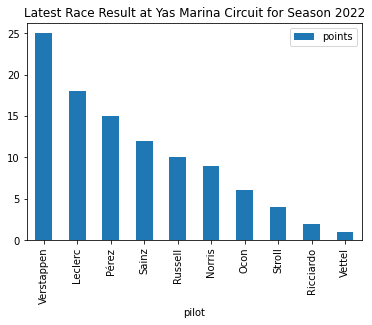

In [5]:
import matplotlib.pyplot as plt
# Get the column value for circuitname at row 0
race_name = df_latest_race.iat[0,3]
# Genereate a title string
title_str = "Latest Race Result at %s for Season 2022"%race_name
# Get data and convert points to int from string.
df_points = df_latest_race.loc[df_latest_race['position'] >= 0, ['points','familyname']]
df_points['points'] = df_points['points'].astype(float)
df_points.sort_values(['points'], ascending=[False])
df_points.rename(columns = {'familyname':'pilot'}, inplace = True)
df_points.plot(x ='pilot', y='points', kind = 'bar')
plt.title(title_str)
plt.show()

# Show us the current winners of season 2022

1. We import matplotlib to be able to graph the data.
2. We fetch only rows from the large Data Frame where position = 1 e.g a racewin and put in a new frame df_wins
3. We group by "familyname" in Data Frame df_wins and then count the number of position = 1, By adding as_index = False the count of position = 1 will be labeled as "position" in the new Data Frame called total_wins. Else the column will have no label and will be hard to plot.
4. We sort the total_wins Data Frame from the counted columns "position" from low to high.
5. We rename the position column to a better name e.g the total number of racewins in Data Frame total_wins
6. Using matplotlib we plot a graph.

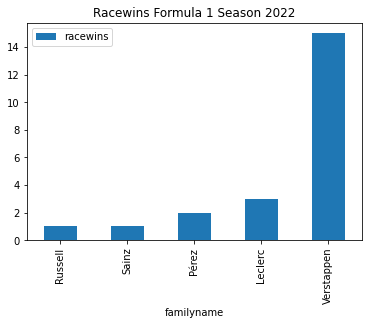

In [6]:
import matplotlib.pyplot as plt
# query only rows in large Data Frame "df" where position is 1 and get columns position and familyname.
df_wins = df.loc[df['position'] == 1, ['position','familyname',]]
# like groupby in SQL!!
total_wins = df_wins.groupby(["familyname"], as_index=False)["position"].count()
# sort the data in ascending order
total_wins.sort_values(by=['position'], inplace=True)
total_wins.rename(columns = {'position':'racewins'}, inplace = True)
total_wins.plot(x ='familyname', y='racewins', kind = 'bar')
plt.title('Racewins Formula 1 Season 2022')
plt.show()

# Show us all pilots total times on podium in season 2022

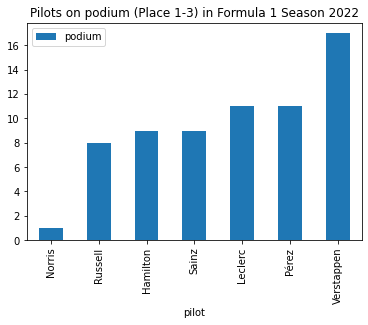

In [7]:
import matplotlib.pyplot as plt
# query only rows in large Data Frame "df" where position is 1-3 and get columns position and familyname.
df_temp = df.loc[df['position'] < 4, ['position','familyname',]]
df_podium = df_temp.groupby(["familyname"], as_index=False)["position"].count()
df_podium.sort_values(by=['position'], inplace=True)
df_podium.rename(columns = {'position':'podium'}, inplace = True)
df_podium.rename(columns = {'familyname':'pilot'}, inplace = True)
df_podium.plot(x ='pilot', y='podium', kind = 'bar')
plt.title('Pilots on podium (Place 1-3) in Formula 1 Season 2022')
plt.show()

# Show all times pilots scored points in Season 2022

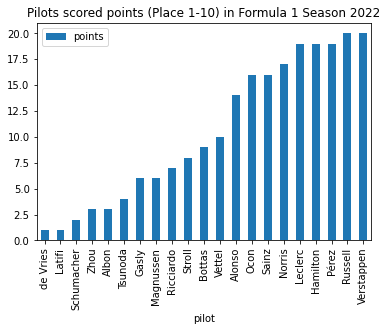

In [8]:
import matplotlib.pyplot as plt
# query only rows in large Data Frame "df" where position is 1 and count the number of times
# a driver scored points (pos 1-10 when raced finished) and group by the driver just as we
# would with a SQL query
df_temp = df.loc[df['position'] < 11, ['position','familyname',]]
df_podium = df_temp.groupby(["familyname"], as_index=False)["position"].count()
df_podium.sort_values(by=['position'], inplace=True)
df_podium.rename(columns = {'position':'points'}, inplace = True)
df_podium.rename(columns = {'familyname':'pilot'}, inplace = True)
df_podium.plot(x ='pilot', y='points', kind = 'bar')
plt.title('Pilots scored points (Place 1-10) in Formula 1 Season 2022')
plt.show()

# Show the current drivers standing for Season 2022

In [9]:
import requests as rq
import pandas as pd
import numpy as np
r = rq.get('https://www.ulfhellstrom.se/ords/f1_access/driverstandings/?q={"season":"2022"}&limit=1000')
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)
data = r.json()
df_driver_standings = pd.json_normalize(data,'items')
# Print number of rows in data set
print(df_driver_standings.shape[0])
# Some options to se all rows and cols
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Remove some columns we do not need in output
df_driver_standings = df_driver_standings.drop(columns=['race','info','constructorinfo'])
# convert points from string to int64
df_driver_standings = df_driver_standings.astype({'points': np.float64})

200
application/json
utf-8
22


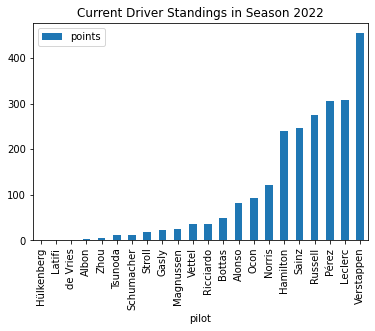

In [10]:
import matplotlib.pyplot as plt
df_driver_standings = df_driver_standings.loc[df_driver_standings['points'] >= 0, ['points','familyname']]
df_driver_standings.sort_values(by=['points'], inplace=True)
df_driver_standings.rename(columns = {'familyname':'pilot'}, inplace = True)
df_driver_standings.plot(x ='pilot', y='points', kind = 'bar')
plt.title('Current Driver Standings in Season 2022')
plt.show()

# Show the current constructors standings in Season 2022

In [11]:
import requests as rq
import pandas as pd
import numpy as np
r = rq.get('https://www.ulfhellstrom.se/ords/f1_access/constructorstandings/?q={"season":"2022"}&limit=1000')
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)
data = r.json()
df_standings = pd.json_normalize(data,'items')
# Print number of rows in data set
print(df_standings.shape[0])
# Some options to se all rows and cols
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Remove some columns we do not need in output
df_standings = df_standings.drop(columns=['race','position','positiontext','wins','constructorinfo'])
# convert points from string to int64
df_standings = df_standings.astype({'points': np.float64})
# Sort the Data Frame by race and place in the race
df_standings.sort_values(by=['points'], inplace=True)

200
application/json
utf-8
10


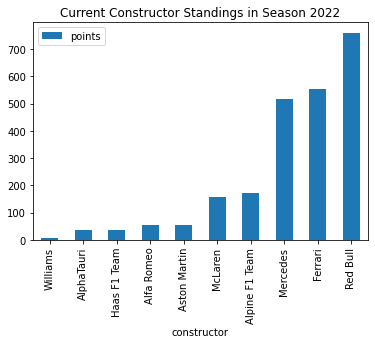

In [12]:
import matplotlib.pyplot as plt
df_standings = df_standings.loc[df_standings['points'] >= 0, ['points','constructorname']]
df_standings.sort_values(by=['points'], inplace=True)
df_standings.rename(columns = {'constructorname':'constructor'}, inplace = True)
df_standings.plot(x ='constructor', y='points', kind = 'bar')
plt.title('Current Constructor Standings in Season 2022')
plt.show()